In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.pydantic_v1 import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END
import os
import json
import time
from dotenv import load_dotenv
from typing import Any, Dict, List, Optional, Literal, TypedDict
from dataclasses import dataclass, asdict

c:\a\envs\env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\a\envs\env2\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", 
    api_key=GOOGLE_API_KEY,
    temperature=0.1)

In [3]:
llm.invoke("Hello, world!").content

'Hello, world!\n'

In [ ]:
class Gemini:
    def __init__(self):
        self.model = ChatGoogleGenerativeAI(
            model="gemini-1.5-flash",
            api_key=GOOGLE_API_KEY,
            temperature=0.1
        )

    def complete(self, system: str, user: str, **kwargs) -> str:
        messages = []
        if system.strip():
            messages.append({"role": "system", "content": system.strip()})
        messages.append({"role": "user", "content": user.strip()})

        resp = self.model.invoke(messages)
        return resp.content if hasattr(resp, "content") else str(resp)


LLM = Gemini()
print(LLM.complete(system="", user="Hello"))

Hello there! How can I help you today?



In [5]:
@dataclass
class Constraint:
    tech_stack : Optional[str] = None
    deployment : Optional[str]= None
    priority : Optional[Literal["high", "medium", "low"]] = None 

In [6]:
@dataclass
class ProjectSpec:
    project_name : str
    description : str
    features : List[str]
    constraints : Constraint

In [7]:
class OrchestratorState(TypedDict, total = False):
    spec : Dict[str, Any]

    #Artifacts 
    user_stories: List[Dict[str, Any]]
    architecture : Dict[str, Any]
    plan : List[Dict[str, Any]]
    code_changes : Dict[str, str]
    tests : Dict[str, str]
    test_report : Dict[str, str]
    ci_cd : Dict[str, str]
    deployment : Dict[str, str]

    #these are for logging each nde in langgraph
    approvals : Dict[str, Any]
    repo_url : Optional[str]
    run_id : Optional[str]

In [8]:
class HitlProvider:
    def request(self, gate: str, payload: Dict[str, Any]) -> Dict[str, Any]:
        raise NotImplementedError


class CLIHitl(HitlProvider):
    def request(self, gate: str, payload: Dict[str, Any]) -> Dict[str, Any]:
        print("\n===== HITL GATE:", gate, "=====")

        print(json.dumps(payload, indent=2)[:4000])

        while True:
            ans = input("Approve? [y/n/e=edit]: ").strip().lower()
            if ans in {"y", "n", "e"}:
                break

        notes = ""

        if ans == "e":
            print("Enter revised JSON (end with an empty line):")
            buf = []
            while True:
                line = input()
                if not line:
                    break
                buf.append(line)
            try:
                revised = json.loads("\n".join(buf))
                payload = revised
            except Exception as e:
                print("Invalid JSON, keeping original:", e)
        
        elif ans == "n":
            notes = input("Reason for rejection? ")
        
        return {"approved": ans == "y", "payload": payload, "notes": notes, "by": "cli-user"}

In [9]:
hitl_provider : HitlProvider = CLIHitl()

In [10]:
def normalize_spec(raw : Dict[str, Any]) -> ProjectSpec:
    constraints = raw.get("constraints") or {}
    return ProjectSpec(
        project_name = raw.get("project_name", "Untitled Project"),
        description = raw.get("description", ""),
        features = raw.get("features", []),
        constraints= Constraint(
            tech_stack = constraints.get("tech_stack"),
            deployment = constraints.get("deployment"),
            priority = constraints.get("priority")
        ),
    )

In [11]:
def to_json(data : Any) -> str:
    return json.dumps(data, indent=2, ensure_ascii=False)

In [12]:
import re
def extract_json(text: str):
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return {}
    return {}
# import json
# import re

# def extract_json(text: str) -> dict:
#     """Extract JSON from LLM response, handling code fences safely."""
#     try:
#         # Strip outer ```json fences
#         cleaned = re.sub(r"^```[a-zA-Z]*\n?", "", text.strip())
#         cleaned = re.sub(r"```$", "", cleaned.strip())

#         # Parse JSON
#         data = json.loads(cleaned)

    #     # If values are strings with ```python fences, strip them too
    #     if isinstance(data, dict):
    #         for k, v in data.items():
    #             if isinstance(v, str):
    #                 v = re.sub(r"^```[a-zA-Z]*\n?", "", v.strip())
    #                 v = re.sub(r"```$", "", v.strip())
    #                 data[k] = v

    #     return data
    # except Exception as e:
    #     print("❌ extract_json failed:", e)
    #     return {}


In [13]:
# def requirements_node(state : OrchestratorState) -> OrchestratorState:
#     spec = normalize_spec(state["spec"])
#     prompt_sys = (
#         "You are a senior product manager. Convert the input spec into precise, testable user stories. "
#         "Use INVEST. Include acceptance criteria and non-functional requirements when relevant."
#     )

#     prompt_user = f"SPEC:\n{to_json(asdict(spec))}\nReturn json with fields: user_stories[]."
    
#     text = LLM.complete(system=prompt_sys, user=prompt_user)
#     print("LLM response:", text[:4000])

#     try:
#         data = json.loads(text)
#         stories = data.get("user_stories", [])
#     except Exception:
#         stories = []
#     return {**state, "user_stories": stories}
    
def requirements_node(state: OrchestratorState) -> OrchestratorState:
    spec = normalize_spec(state["spec"])
    prompt_sys = (
        "You are a senior product manager. Convert the input spec into precise, testable user stories. "
        "Use INVEST. Include acceptance criteria and non-functional requirements when relevant."
    )
    prompt_user = f"SPEC:\n{to_json(asdict(spec))}\nReturn JSON with fields: user_stories[]."

    text = LLM.complete(system=prompt_sys, user=prompt_user)
    # print("LLM response (truncated):", text[:1000])

    # Extract the first valid JSON object
    data = extract_json(text)
    stories = data.get("user_stories", [])
    return {**state, "user_stories": stories}


In [14]:
if __name__ == "__main__":
    sample_state = {
        "spec": {
            "project_name": "Task Manager",
            "description": "A simple task management app",
            "features": ["add task", "list tasks", "mark task done"],
            "constraints": {"tech_stack": "Python + FastAPI"}
        }
    }

    result = requirements_node(sample_state)
    print(json.dumps(result, indent=2))

{
  "spec": {
    "project_name": "Task Manager",
    "description": "A simple task management app",
    "features": [
      "add task",
      "list tasks",
      "mark task done"
    ],
    "constraints": {
      "tech_stack": "Python + FastAPI"
    }
  },
  "user_stories": [
    {
      "id": "US001",
      "title": "As a user, I want to add a new task to the task manager so that I can keep track of my to-dos.",
      "description": "Allows users to add tasks with a description and optional due date.",
      "acceptance_criteria": [
        "The system shall allow users to input a task description (text field, minimum 1 character).",
        "The system shall allow users to optionally input a due date (date picker).",
        "The system shall display a success message upon successful task creation.",
        "The system shall handle invalid input (e.g., empty description) gracefully with appropriate error messages.",
        "The newly added task should be immediately visible in the

In [15]:
def hitl_gate(state : OrchestratorState, gate : str, payload_keys : List[str]) -> OrchestratorState:
    payload = {k: state.get(k) for k in payload_keys}
    decision = hitl_provider.request(gate, payload)
    
    approvals = state.get("approvals", {})
    approvals[gate] = {k: v for k, v in decision.items() if k != "payload"}
    
    #allowing the human edits
    updated = {**state, **(decision.get("payload", {}))}
    updated["approvals"] = approvals
    if not decision.get("approved", True):
        raise Exception(f"Gate {gate} rejected: {decision.get('notes', 'No reason provided')}")
    return updated

In [16]:
def design_node(state : OrchestratorState) -> OrchestratorState:
    spec = normalize_spec(state["spec"])

    prompt_sys = (
        "You are a pragmatic software architect. Propose a simple, scalable architecture. "
        "Include: system diagram (text), services, data model, API contracts, and key trade-offs."
    )
    prompt_user = (
        f"PROJECT: {spec.project_name}\nDESC: {spec.description}\nFEATURES: {to_json(spec.features)}\n"
        f"CONSTRAINTS: {to_json(asdict(spec.constraints))}\nReturn JSON field 'architecture'."
    )

    text = LLM.complete(system=prompt_sys, user=prompt_user)
    # print("LLM raw response:", text[:100])

    data = extract_json(text)
    arch = data.get("architecture", {})

    return {**state, "architecture": arch}


In [17]:
if __name__ == "__main__":
    sample_state = {
        "spec": {
            "project_name": "Task Manager",
            "description": "A simple task management app",
            "features": ["add task", "list tasks", "mark task done"],
            "constraints": {"tech_stack": "Python + FastAPI"}
        }
    }

    result = design_node(sample_state)
    print("=== Final Output ===")
    print(json.dumps(result, indent=2))


=== Final Output ===
{
  "spec": {
    "project_name": "Task Manager",
    "description": "A simple task management app",
    "features": [
      "add task",
      "list tasks",
      "mark task done"
    ],
    "constraints": {
      "tech_stack": "Python + FastAPI"
    }
  },
  "architecture": {
    "description": "A simple, scalable microservice architecture for a task manager using Python and FastAPI.  This design prioritizes simplicity and ease of scaling for future features.",
    "system_diagram": "```\nClient (e.g., Web App, Mobile App) --(API Calls)--> API Gateway --(gRPC)--> Task Service --(gRPC)--> Database\n```",
    "services": [
      {
        "name": "API Gateway",
        "description": "Handles routing of API requests, authentication, and rate limiting.  Can be implemented using FastAPI itself or a dedicated gateway like Kong.",
        "technology": "FastAPI"
      },
      {
        "name": "Task Service",
        "description": "Manages core task operations: creati

In [18]:
def planning_node(state: OrchestratorState) -> OrchestratorState:
    prompt_sys = (
        "You are an agile tech lead. Turn user stories and architecture into a plan: "
        "epics, tasks, estimates, and dependencies."
    )
    
    prompt_user = (
        f"Stories: {to_json(state.get('user_stories', []))}\n"
        f"Arch: {to_json(state.get('architecture', {}))}\n"
        f"Return JSON with field 'plan' as a list."
    )

    text = LLM.complete(system=prompt_sys, user=prompt_user)
    # print("LLM raw response (truncated):", text[:10])  

    data = extract_json(text)
    plan = data.get("plan", [])

    return {**state, "plan": plan}


In [19]:
if __name__ == "__main__":
    sample_state = {
        "spec": {
            "project_name": "Task Manager",
            "description": "A simple task management app",
            "features": ["add task", "list tasks", "mark task done"],
            "constraints": {"tech_stack": "Python + FastAPI"}
        },
        "user_stories": [
            {
                "id": "US001",
                "title": "As a user, I want to add a task",
                "acceptance_criteria": [
                    "User can enter a task description",
                    "Task is saved and visible in task list"
                ],
                "priority": "High"
            },
            {
                "id": "US002",
                "title": "As a user, I want to list my tasks",
                "acceptance_criteria": [
                    "System shows all tasks with descriptions",
                    "Tasks can be sorted by due date"
                ],
                "priority": "High"
            }
        ],
        "architecture": {
            "services": [
                {"name": "API Gateway", "description": "Handles incoming API requests"},
                {"name": "Task Service", "description": "Manages task CRUD operations"}
            ]
        }
    }

    result = planning_node(sample_state)

    print("=== Final Plan Output ===")
    print(json.dumps(result, indent=2))


=== Final Plan Output ===
{
  "spec": {
    "project_name": "Task Manager",
    "description": "A simple task management app",
    "features": [
      "add task",
      "list tasks",
      "mark task done"
    ],
    "constraints": {
      "tech_stack": "Python + FastAPI"
    }
  },
  "user_stories": [
    {
      "id": "US001",
      "title": "As a user, I want to add a task",
      "acceptance_criteria": [
        "User can enter a task description",
        "Task is saved and visible in task list"
      ],
      "priority": "High"
    },
    {
      "id": "US002",
      "title": "As a user, I want to list my tasks",
      "acceptance_criteria": [
        "System shows all tasks with descriptions",
        "Tasks can be sorted by due date"
      ],
      "priority": "High"
    }
  ],
  "architecture": {
    "services": [
      {
        "name": "API Gateway",
        "description": "Handles incoming API requests"
      },
      {
        "name": "Task Service",
        "description":

In [20]:
def implementation_node(state: OrchestratorState) -> OrchestratorState:
    spec = normalize_spec(state["spec"])
    prompt_sys = (
        "You are a senior engineer. Generate minimal, production-ready code skeletons with docstrings and TODOs. "
        "Prefer simplicity and testability."
    )
    
    prompt_user = (
    f"Tech stack: {spec.constraints.tech_stack}\nPlan: {to_json(state.get('plan', []))}\n"
    "Output JSON with key 'code_changes' as {filename: content}. "
    "IMPORTANT: Return raw JSON only. Do not wrap code in markdown fences (no ```python, no ```). "
    "Each file's content must be a plain string value inside JSON."
    )


    text = LLM.complete(prompt_sys, prompt_user)
    print("LLM raw response (truncated):", text[:500])  

    try:
        data = extract_json(text)
        code_changes = data.get("code_changes", {})
    except Exception as e:
        print("Failed to parse JSON:", e)
        code_changes = {}

    return {**state, "code_changes": code_changes}


In [21]:
if __name__ == "__main__":
    sample_state = {
        "spec": {
            "project_name": "Task Manager",
            "description": "A simple task management app",
            "features": ["add task", "list tasks", "mark task done"],
            "constraints": {"tech_stack": "Python + FastAPI"}
        },
        "plan": [
            {
                "epic": "Task CRUD",
                "tasks": [
                    {"id": "T001", "description": "Implement add task API", "estimate": "2d"},
                    {"id": "T002", "description": "Implement list tasks API", "estimate": "1d"}
                ]
            }
        ]
    }

    result = implementation_node(sample_state)

    print("=== Final Code Changes ===")
    for filename, content in result.get("code_changes", {}).items():
        print(f"\n--- {filename} ---\n{content[:300]}...\n")


LLM raw response (truncated): ```json
{
  "code_changes": {
    "app/main.py": "'''\nFastAPI application.\n'''\n\nfrom fastapi import FastAPI, HTTPException\nfrom pydantic import BaseModel\n\napp = FastAPI()\n\nclass Task(BaseModel):\n    id: int\n    description: str\n    completed: bool = False\n\n# TODO: Replace with a persistent storage (e.g., database)\ntasks = []\n\n@app.post(\"/tasks/\")\ndef add_task(task: Task):\n    \"\"\"Add a new task.\n    \"\"\"\n    # TODO: Handle potential errors (e.g., duplicate IDs)\n    ta
=== Final Code Changes ===

--- app/main.py ---
'''
FastAPI application.
'''

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

app = FastAPI()

class Task(BaseModel):
    id: int
    description: str
    completed: bool = False

# TODO: Replace with a persistent storage (e.g., database)
tasks = []

@app.post("/tasks/")
d...


--- app/tests/test_main.py ---
'''
Tests for the FastAPI application.
'''

import pytest
from fastapi.testclient im

In [22]:
def testing_node(state : OrchestratorState) -> OrchestratorState:
    prompt_sys = (
        "You are a test engineer. Generate unit & integration tests to cover core behaviors."
    )
    prompt_user = (
        f"Given code files: {list((state.get('code_changes') or {}).keys())}\n"
        "Return JSON with 'tests' (filename->content) and 'test_plan' summary."
    )

    text = LLM.complete(prompt_sys, prompt_user)

    print("LLM raw response (truncated):", text[:500])

    tests: Dict[str, str]
    test_plan: Dict[str, Any]

    try:
        data = extract_json(text)
        tests = data.get("tests", {})
        test_plan = data.get("test_plan", {})

    except Exception as e:
        print("Failed to parse:", e)
        tests, test_plan = {}, {}


    report = {"summary": "stubbed", "passed": True, "coverage": 0.0, "notes": "Replace with real runner"}
    return {**state, "tests": tests, "test_plan": test_plan, "test_report": report}


In [23]:
if __name__ == "__main__":
    # simulate state coming out of implementation_node
    sample_state = {
        "spec": {
            "project_name": "Task Manager",
            "description": "A simple task management app",
            "features": ["add task", "list tasks", "mark task done"],
            "constraints": {"tech_stack": "Python + FastAPI"}
        },
        "code_changes": {
            "api/tasks.py": """\"\"\"Tasks API\"\"\"
from fastapi import APIRouter

router = APIRouter()

@router.get("/tasks")
def list_tasks():
    return []  # TODO: implement
"""
        }
    }

    result = testing_node(sample_state)

    print("\n=== Generated Test Plan ===")
    print(result.get("test_plan", {}))

    print("\n=== Generated Tests ===")
    for filename, content in result.get("tests", {}).items():
        print(f"\n--- {filename} ---\n{content[:300]}...\n")  # preview first 300 chars

    print("\n=== Test Report (stubbed) ===")
    print(result.get("test_report"))

LLM raw response (truncated): ```json
{
  "tests": {
    "test_api_tasks.py": "import unittest\nimport json\nfrom unittest.mock import patch\nfrom api.tasks import create_task, get_task, update_task, delete_task\n\n# Sample Task Data\nsample_task = {'id': 1, 'title': 'Test Task', 'description': 'This is a test task', 'completed': False}\n\nclass TestTasksAPI(unittest.TestCase):\n\n    @patch('api.tasks.db') # Mocking database interaction\n    def test_create_task(self, mock_db):\n        mock_db.insert_one.return_value = {'i

=== Generated Test Plan ===
Unit Tests:

* **create_task:** Tests successful task creation, verifies data integrity, and checks database interaction using mocking.
* **get_task:** Tests successful retrieval of a task, handles cases where the task is not found, and verifies database interaction.
* **update_task:** Tests successful task updates, handles cases where the task is not found, and verifies database interaction.
* **delete_task:** Tests successful task del

In [24]:
def deployment_node(state: OrchestratorState) -> OrchestratorState:
    spec = normalize_spec(state["spec"])  

    prompt_sys = (
        "You are a DevOps engineer. Produce CI/CD config and containerization files. "
        "Return valid JSON only, no markdown code fences, no explanations."
    )

    prompt_user = (
        f"Deployment: {getattr(spec.constraints, 'deployment', 'unspecified')}\n"
        "Output JSON with:\n"
        "  - 'ci_cd': {filename: content}, where content is plain text (no markdown fences)\n"
        "  - 'deployment': {strategy, envs}"
    )

    text = LLM.complete(prompt_sys, prompt_user)
    print("LLM raw response (truncated):", text[:500])

    try:
        cleaned = text.strip()
        if cleaned.startswith("```"):
            cleaned = re.sub(r"^```(json)?", "", cleaned, flags=re.IGNORECASE).strip()
        if cleaned.endswith("```"):
            cleaned = cleaned[:-3].strip()

        data = json.loads(cleaned)
        ci_cd = data.get("ci_cd", {})
        deployment = data.get("deployment", {})
    except Exception as e:
        print("Failed to parse deployment JSON:", e)
        ci_cd, deployment = {}, {}

    return {**state, "ci_cd": ci_cd, "deployment": deployment}


In [25]:
if __name__ == "__main__":
    sample_state = {
        "spec": {
            "project_name": "Task Manager",
            "description": "A simple task management app",
            "features": ["add task", "list tasks", "mark task done"],
            "constraints": {
                "tech_stack": "Python + FastAPI",
                "deployment": "Docker + GitHub Actions"
            }
        }
    }

    result = deployment_node(sample_state)

    print("=== Generated CI/CD Configs ===")
    for filename, content in result.get("ci_cd", {}).items():
        print(f"\n--- {filename} ---\n{content[:300]}...\n")  # preview first 300 chars

    print("=== Deployment Strategy ===")
    print(result.get("deployment", {}))


LLM raw response (truncated): ```json
{
  "ci_cd": {
    "filename": ".github/workflows/main.yml",
    "content": "name: CI/CD\n\non: \n  push:\n    branches:\n      - main\n\njobs:\n  build:\n    runs-on: ubuntu-latest\n    steps:\n      - uses: actions/checkout@v3\n      - name: Build the Docker image\n        run: docker build -t my-app:latest .\n      - name: Log in to Docker Hub\n        run: docker login -u ${{ secrets.DOCKERHUB_USERNAME }} -p ${{ secrets.DOCKERHUB_PASSWORD }}\n      - name: Push the Docker image\n    
=== Generated CI/CD Configs ===

--- filename ---
.github/workflows/main.yml...


--- content ---
name: CI/CD

on: 
  push:
    branches:
      - main

jobs:
  build:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Build the Docker image
        run: docker build -t my-app:latest .
      - name: Log in to Docker Hub
        run: docker login -u ${{ secrets.D...

=== Deployment Strategy ===
{'strategy': 'Docker + Kubernetes', 'e

In [26]:
def build_graph() -> Any:
    graph = StateGraph(OrchestratorState)

    # Core nodes
    graph.add_node("requirements_node", requirements_node)
    graph.add_node("design_node", design_node)
    graph.add_node("planning_node", planning_node)
    graph.add_node("implementation_node", implementation_node)
    graph.add_node("testing_node", testing_node)
    graph.add_node("deployment_node", deployment_node)

    # HITL nodes
    graph.add_node("hitl_requirements_node", lambda s: hitl_gate(s, "requirements_review", ["user_stories"]))
    graph.add_node("hitl_design_node", lambda s: hitl_gate(s, "architecture_review", ["architecture"]))
    graph.add_node("hitl_preprod_node", lambda s: hitl_gate(s, "preprod_release", ["test_report", "ci_cd"]))
    graph.add_node("hitl_prod_node", lambda s: hitl_gate(s, "prod_release", ["deployment"]))

    # Entry point
    graph.set_entry_point("requirements_node")

    # Edges
    graph.add_edge("requirements_node", "hitl_requirements_node")
    graph.add_edge("hitl_requirements_node", "design_node")
    graph.add_edge("design_node", "hitl_design_node")
    graph.add_edge("hitl_design_node", "planning_node")
    graph.add_edge("planning_node", "implementation_node")
    graph.add_edge("implementation_node", "testing_node")
    graph.add_edge("testing_node", "hitl_preprod_node")
    graph.add_edge("hitl_preprod_node", "deployment_node")
    graph.add_edge("deployment_node", "hitl_prod_node")
    graph.add_edge("hitl_prod_node", END)

    # checkpointer = MemorySaver()
    return graph.compile()


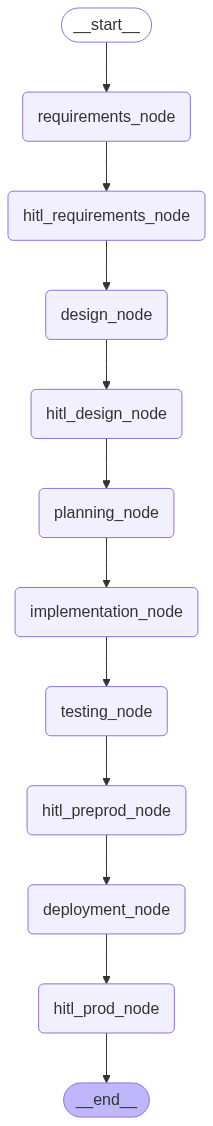

In [27]:
build_graph()

In [28]:
def example_input() -> Dict[str, Any]:
    return {
        "project_name": "Task Manager",
        "description": "A simple web app to track personal tasks and reminders",
        "features": [
            "User authentication",
            "Task CRUD",
            "Due date reminders",
            "Tags and filters",
        ],
        "constraints": {
            "tech_stack": "React + FastAPI + Postgres",
            "deployment": "docker",
            "priority": "high",
        },
    }


In [31]:
def run_once():
    workflow = build_graph()
    init: OrchestratorState = {
        "spec": example_input(),
        "approvals": {},
        "repo_url": None,
        "run_id": str(int(time.time())),
    }

    print("Starting orchestrator…\n")
    final = None
    for event in workflow.stream(init):
        for node, payload in event.items():
            if node == "__end__":
                continue
            print(f"\n>>> Node: {node}")
            keys = list(payload.keys())
            print("State keys:", keys)
    final = workflow.invoke(init)

    print("\n\n=== FINAL STATE KEYS ===")
    print(list(final.keys()))
    with open(r"C:\Advance_Projects\Automated-SDLC\output\final_state.json", "w", encoding="utf-8") as f:
        json.dump(final, f, indent=2, ensure_ascii=False)
    print(r"Final state saved to C:\Advance_Projects\Automated-SDLC\output\final_state.json")

In [32]:
run_once()

Starting orchestrator…


>>> Node: requirements_node
State keys: ['spec', 'approvals', 'repo_url', 'run_id', 'user_stories']

===== HITL GATE: requirements_review =====
{
  "user_stories": [
    {
      "id": 1,
      "title": "As a user, I want to be able to create an account so that I can securely store my tasks.",
      "description": "This story covers the creation of new user accounts.",
      "acceptance_criteria": [
        "User can navigate to a signup page.",
        "User can fill in a form with username, email, and password.",
        "System validates email format and password strength (minimum 8 characters, one uppercase, one number).",
        "Upon successful signup, user is redirected to the task list page.",
        "System sends a confirmation email (optional, but preferred).",
        "System handles duplicate email addresses gracefully."
      ],
      "priority": "high",
      "notes": "Consider using a robust password hashing algorithm (e.g., bcrypt)."
    },
   